# コード5-1：MCMCを用いたベイズ推定の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

MCMCを用いたベイズ推定の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

- RStan https://mc-stan.org/users/interfaces/rstan

In [300]:
## 必要があればインストール
# install.packages(c("rstan", "ggplot2", "patchwork", "deSolve"))

In [179]:
rm(list = ls(all = TRUE))
library(rstan)
library(ggplot2)
library(patchwork)
library(deSolve)

## MCMCを用いたベイズ推定

式(3.3)

$$
F_{A,co}=\frac{1}{\left(1+\frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} -\frac{1}{\left(1 + \frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right) \right)^p} , \\
F_{B,co} = 1 - \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} - \frac{1}{\left(1+ \frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} + \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p}, \\
F_{C,co} = \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}} + V ̅_{\text{HSA}} \right)\right)^p} , \\
F_{D,co} = \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} -\frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p} .)
$$

において、各区画の割合が得られたときに、パラメータ$p, \frac{\beta}{q} V_{\text{HSA}}, \frac{\beta}{q} V_{\text{GFP}}, j_{6.25}, , j_{12.5}, j_{25}, j_{37}, j_{50}, j_{75}, j_{100}, j_{200}$を推定する。

`rstan`パッケージを用いて行う

参考：

- Remion et al. Virology 2016  
https://doi.org/10.1016/j.virol.2015.09.028
- Ito et al. Sci Rep 2017  
https://doi.org/10.1038/s41598-017-03954-9
- Ito et al. J Theor Biol 2018

In [180]:
## p, beta*V_HSA/q, beta*V_GFP/q, j_6.25, j_12.5, j_25, j_37, j_50, j_75, j_100, j_200
pars <- c(1.176, #p
          1.484*(10.0^-2.0), #beta*V_HSA/q
          2.115*(10.0^-2.0), #beta*V_GFP/q
          2.417, #j_6.25
          4.231, #j_12.5
          4.352, #j_25
          11.09, #j_37
          8.115, #j_50
          12.79, #j_75
          16.75, #j_100
          26.87) #j_200

In [181]:
## 式(3.3)
model_coinfection <- function(c_hsa, c_gfp, parms) {
    
    p <- parms[1]
    beta_vhsa_q <- parms[2]
    beta_vgfp_q <- parms[3]
    j625 <- parms[4]
    j125 <- parms[5]
    j25 <- parms[6]
    j37 <- parms[7]
    j50 <- parms[8]
    j75 <- parms[9]
    j100 <- parms[10]
    j200 <- parms[11]
    
    j_scale_hsa <- scale_par(c_hsa, parms[4:11])
    j_scale_gfp <- scale_par(c_gfp, parms[4:11])
    
    f_a_co <- 0.0; f_b_co <- 0.0; f_c_co <- 100.0; f_d_co <- 0.0
    
    f_hsa <- 1.0/((1.0 + beta_vhsa_q*j_scale_hsa)^p)
    f_gfp <- 1.0/((1.0 + beta_vgfp_q*j_scale_gfp)^p)
    f_hsagfp <- 1.0/((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp)^p)
    
    if (c_hsa > 0 & c_gfp > 0) {
        f_a_co <- f_gfp - f_hsagfp
        f_b_co <- 1 - f_gfp - f_hsa + f_hsagfp
        f_c_co <- f_hsagfp
        f_d_co <- f_hsa - f_hsagfp
    } else if (c_hsa > 0) {
        f_a_co <- 1 - f_hsa
        f_b_co <- 0.0
        f_c_co <- f_hsa
        f_d_co <- 0.0
    } else if (c_gfp > 0) {
        f_a_co <- 0.0
        f_b_co <- 0.0
        f_c_co <- f_gfp
        f_d_co <- 1 - f_gfp
    } else {
        print('"At least one viral dose must be greater than 0."')
        return("At least one viral dose must be greater than 0.")
    }
     
    
    return(c(100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co))
}

scale_par <- function(effective_virus, scales) {
    if (effective_virus == 3.12) {
        return(1.0)
    } else if (effective_virus == 6.25) {
        return(scales[1])
    } else if (effective_virus == 12.5) {
        return(scales[2])
    } else if (effective_virus == 25) {
        return(scales[3])
    } else if (effective_virus == 37) {
        return(scales[4])
    } else if (effective_virus == 50) {
        return(scales[5])
    } else if (effective_virus == 75) {
        return(scales[6])
    } else if (effective_virus == 100) {
        return(scales[7])
    } else if (effective_virus == 200) {
        return(scales[8])
    } else if (effective_virus == 0.0) {
        return(0.0)
    } else {
        print('error: "Invalid dose"')
        return("Invalid dose")
    }
}

In [182]:
## ノイズを加えてデータを生成

dose_hsa_single <- c(3.12, 6.25, 12.5, 25, 37, 50, 75, 100, 100, 200)
dose_gfp_single <- c(3.12, 6.25, 12.5, 25, 50, 50, 75, 100, 100, 200)

dose_hsa_co1 <- c(25, 50, 100)
dose_hsa_co2 <- c(37, 75, 100)
dose_gfp_co1 <- c(25, 50, 100)
dose_gfp_co2 <- c(50, 75, 100)

dose_hsa <- c(dose_hsa_single, rep(0, length(dose_gfp_single)),
              rep(dose_hsa_co1, each = length(dose_gfp_co1)),
              rep(dose_hsa_co2, each = length(dose_gfp_co2)))

dose_gfp <- c(rep(0, length(dose_hsa_single)), dose_gfp_single,
              rep(dose_gfp_co1, length(dose_hsa_co1)),
              rep(dose_gfp_co2, length(dose_hsa_co2)))

dose_exp <- data.frame(hsa = dose_hsa, gfp = dose_gfp)

for (i in 1:nrow(dose_exp)) {
    freq_true <- model_coinfection(dose_exp$hsa[i], dose_exp$gfp[i], pars)
    freq_gen <- model_coinfection(dose_exp$hsa[i], dose_exp$gfp[i], pars)*
        runif(n = 4, min = 0.6, max = 1.4)
    freq_gen <- 100*freq_gen/sum(freq_gen)
    if (i == 1) {
        data_true <- freq_true
        data_gen <- freq_gen
    } else {
        data_true <- rbind(data_true, freq_true)
        data_gen <- rbind(data_gen, freq_gen)
    }
}
rownames(data_true) <- NULL
rownames(data_gen) <- NULL

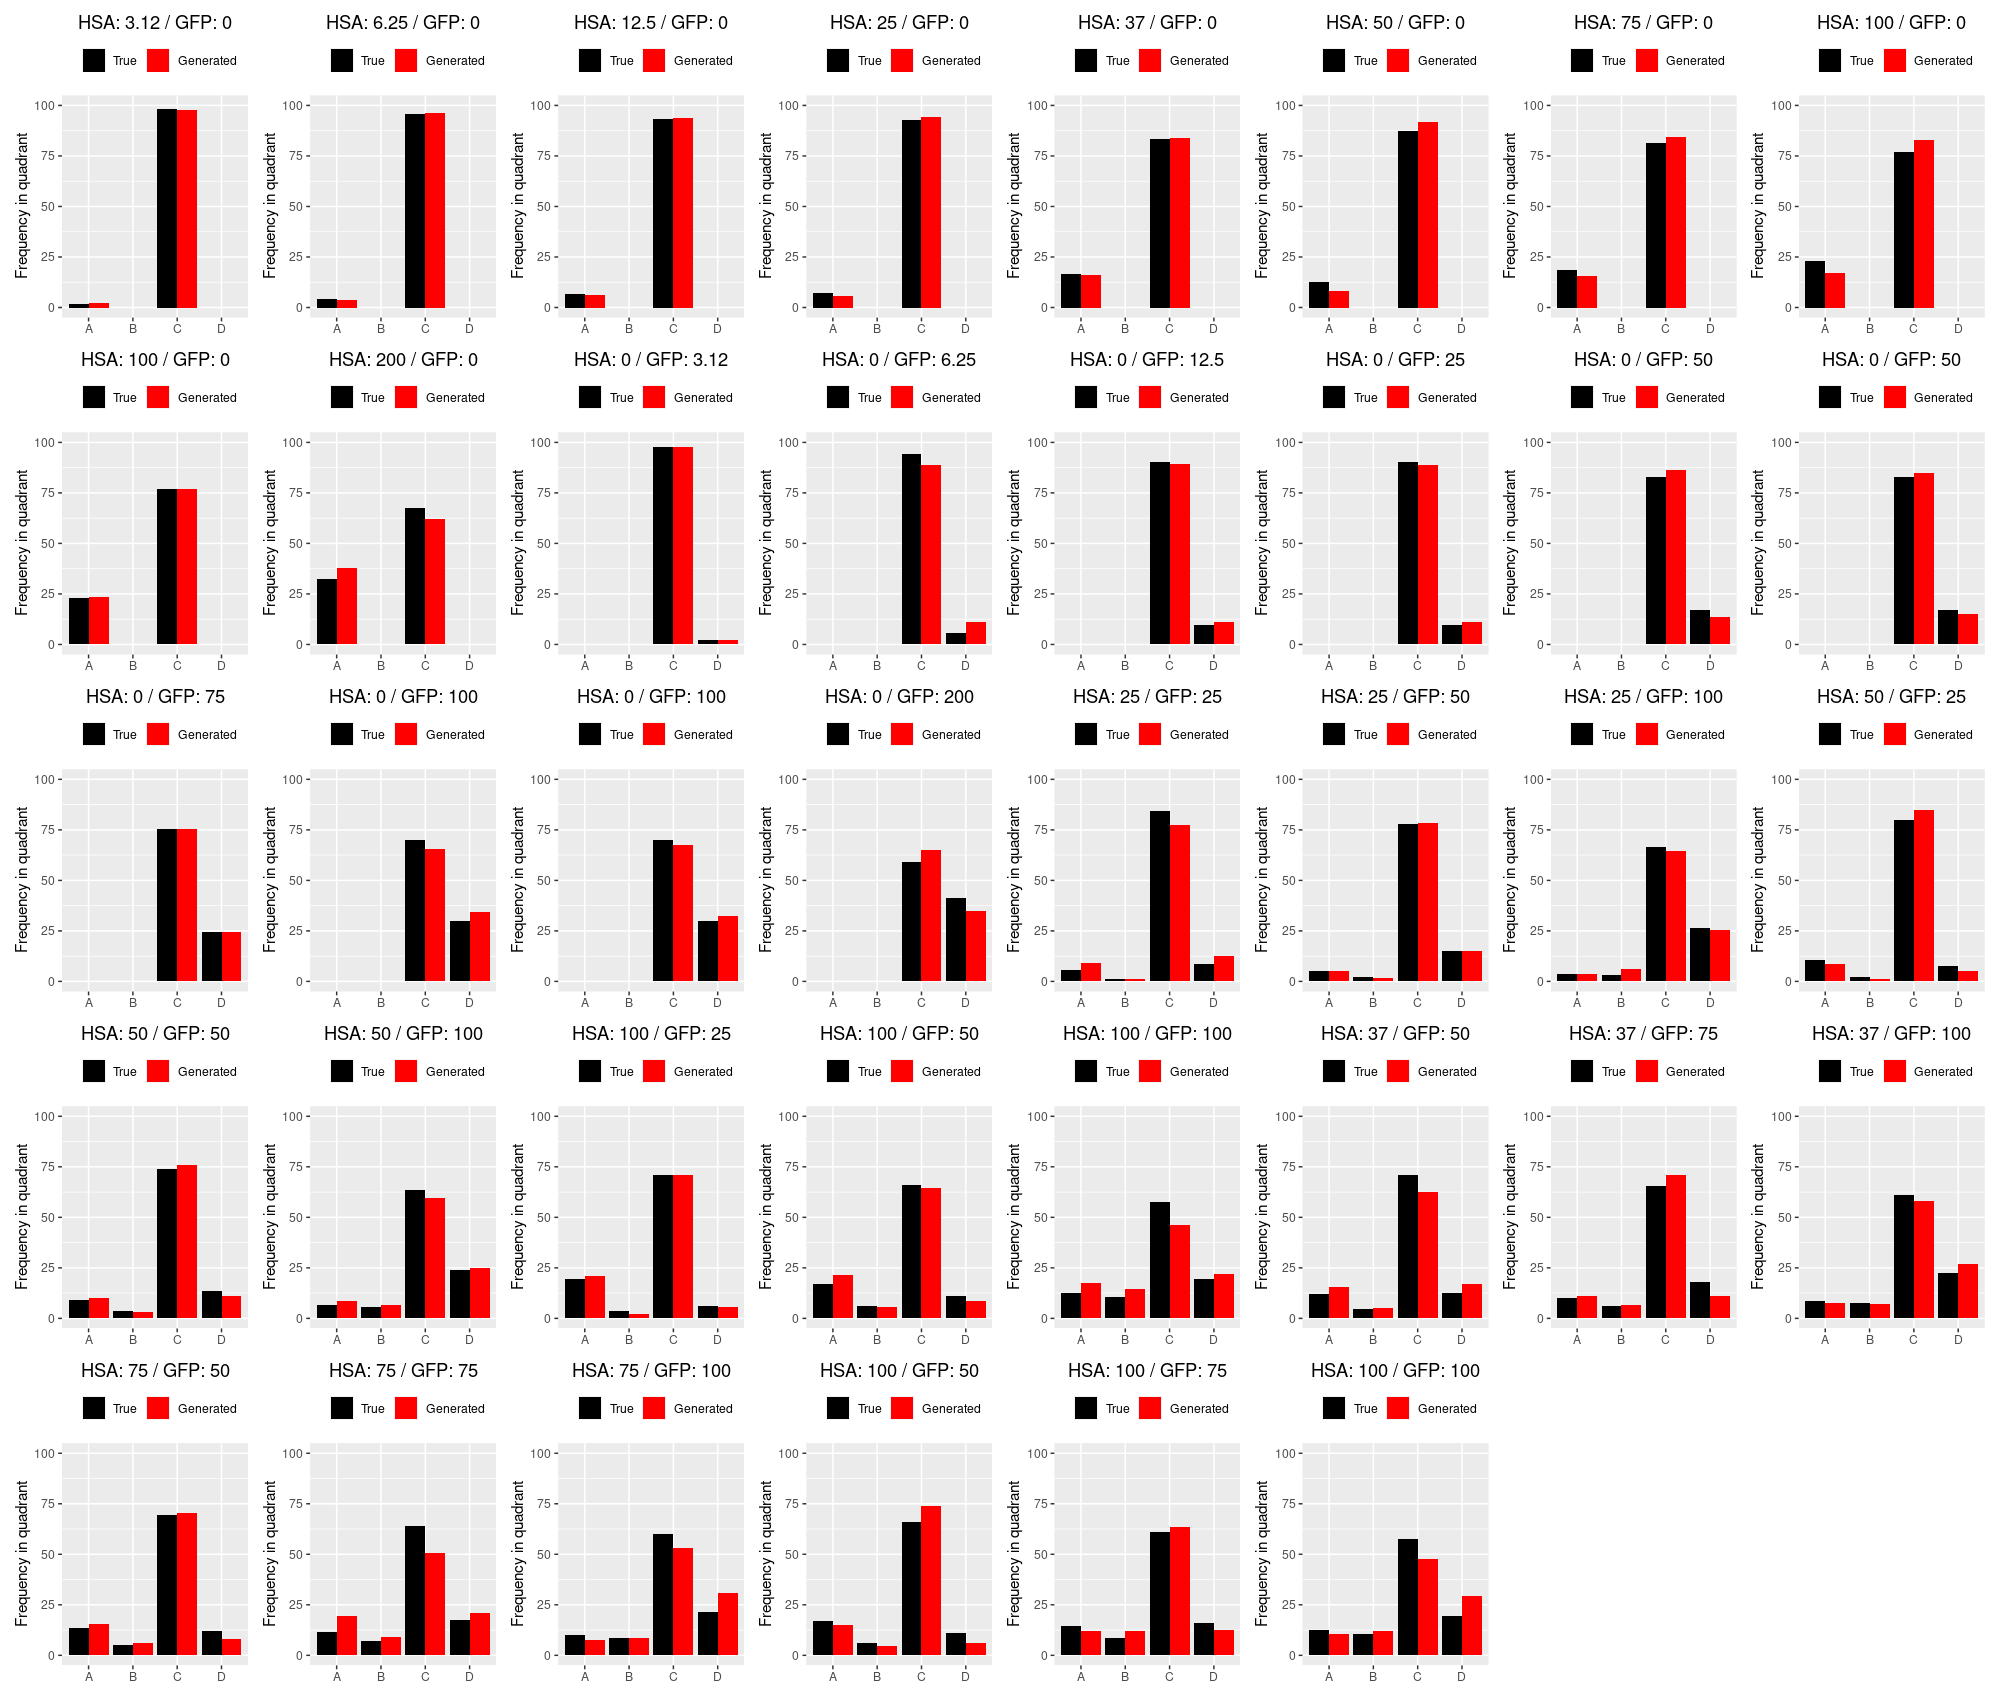

In [183]:
## データのプロット

plt <- list()

for (i in 1:nrow(data_true)) {
    data_temp <- rbind(data.frame(x = LETTERS[1:4], y = data_true[i, ], label = "True"),
                       data.frame(x = LETTERS[1:4], y = data_gen[i, ], label = "Generated"))
    data_temp$label <- factor(data_temp$label, levels = c("True", "Generated"))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = label)) +
        geom_bar(stat = "identity", position = "dodge") +
        scale_fill_manual(values = c(True = "black", Generated = "red")) +
        scale_y_continuous(limits = c(0, 100)) +
        ylab("Frequency in quadrant") +
        labs(title = paste("HSA:", dose_exp$hsa[i], "/ GFP:", dose_exp$gfp[i])) +
        theme(legend.position = 'top',
              legend.title = element_blank(),
              axis.title.x = element_blank(),
              plot.title = element_text(hjust = 0.5))
}

options(repr.plot.width = 20, repr.plot.height = 17, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(ncol = 8)

In [184]:
model_stan_coinfection <- "
functions {
  
  real scale_par(int effective_virus, array[] real scales) {
    if (effective_virus == 1) {
        return 1.0;
    } else if (effective_virus > 1 && effective_virus < 10) {
        return scales[effective_virus + 2];
    }  else if (effective_virus == 0) {
        return 0.0;
    } else {
        return 1000000.0;
    }
  }
  array[] real model_coinfection(int c_hsa, int c_gfp, array[] real parms, int expt_type) {
    real p = parms[1];
    real beta_vhsa_q = parms[2];
    real beta_vgfp_q = parms[3];
    
    real j_scale_hsa = scale_par(c_hsa, parms);
    real j_scale_gfp = scale_par(c_gfp, parms);
    
    real f_a_co = 0.0; real f_b_co = 0.0; real f_c_co = 100.0; real f_d_co = 0.0;
    
    real f_hsa = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa), p);
    real f_gfp = 1.0/pow((1.0 + beta_vgfp_q*j_scale_gfp), p);
    real f_hsagfp = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p);
    
    if (c_hsa > 0 && c_gfp > 0) {
        f_a_co = f_gfp - f_hsagfp;
        f_b_co = 1.0 - f_gfp - f_hsa + f_hsagfp;
        f_c_co = f_hsagfp;
        f_d_co = f_hsa - f_hsagfp;
    } else if (c_hsa > 0) {
        f_a_co = 1.0 - f_hsa;
        f_b_co = 0.0;
        f_c_co = f_hsa;
        f_d_co = 0.0;
    } else if (c_gfp > 0) {
        f_a_co = 0.0;
        f_b_co = 0.0;
        f_c_co = f_gfp;
        f_d_co = 1.0 - f_gfp;
    } else {
    
    }
    
    if (expt_type == 1) {
      return {100.0*f_a_co, 100.0*f_c_co};
    } else if (expt_type == 2) {
      return {100.0*f_c_co, 100.0*f_d_co};
    } else {
      return {100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co};
    }
    
  }
  
  
}
data {
  int<lower=0> num_expt_HSA_single;         // number of experiments
  int<lower=0> num_expt_GFP_single;         // number of experiments
  int<lower=0> num_expt_co;         // number of experiments
  int<lower=0> num_quad_HSA_single;      // number of quadorants
  int<lower=0> num_quad_GFP_single;      // number of quadorants
  int<lower=0> num_quad_co;      // number of quadorants
  array[num_expt_HSA_single, num_quad_HSA_single] real freqs_HSA_single;   // frequency
  array[num_expt_GFP_single, num_quad_GFP_single] real freqs_GFP_single;   // frequency
  array[num_expt_co, num_quad_co] real freqs_co;   // frequency
  array[num_expt_HSA_single, 2] int conc_HSA_single;  //effective virus titier, HSA, GFP
  array[num_expt_GFP_single, 2] int conc_GFP_single;  //effective virus titier, HSA, GFP
  array[num_expt_co, 2] int conc_co;  //effective virus titier, HSA, GFP
}
parameters {
  // model parameters
  real<lower=log(0.01), upper=log(100.0)> p;
  real<lower=log(0.0001), upper=log(1.0)> beta_vhsa_q;
  real<lower=log(0.0001), upper=log(1.0)> beta_vgfp_q;
  real<lower=log(0.01), upper=log(100.0)> j625;
  real<lower=log(0.01), upper=log(100.0)> j125;
  real<lower=log(0.01), upper=log(100.0)> j25;
  real<lower=log(0.01), upper=log(100.0)> j37;
  real<lower=log(0.01), upper=log(100.0)> j50;
  real<lower=log(0.01), upper=log(100.0)> j75;
  real<lower=log(0.01), upper=log(100.0)> j100;
  real<lower=log(0.01), upper=log(100.0)> j200;
  
  // standard deviation of error model
  real<lower=0, upper=1000.0> sigma;
}
transformed parameters{
  array[num_expt_HSA_single, num_quad_HSA_single] real y_HSA_single;
  array[num_expt_GFP_single, num_quad_GFP_single] real y_GFP_single;
  array[num_expt_co, num_quad_co] real y_co;
  {
    array[11] real parms;
    parms[1] = exp(p); parms[2] = exp(beta_vhsa_q); parms[3] = exp(beta_vgfp_q);
    parms[4] = exp(j625); parms[5] = exp(j125); parms[6] = exp(j25); parms[7] = exp(j37);
    parms[8] = exp(j50); parms[9] = exp(j75); parms[10] = exp(j100); parms[11] = exp(j200);
    
    // HSA single
    for (i in 1:num_expt_HSA_single) {
      y_HSA_single[i,] = model_coinfection(conc_HSA_single[i, 1], conc_HSA_single[i, 2], parms, 1);
    }
    // GFP single
    for (i in 1:num_expt_GFP_single) {
      y_GFP_single[i,] = model_coinfection(conc_GFP_single[i, 1], conc_GFP_single[i, 2], parms, 2);
    }
    // coinfection
    for (i in 1:num_expt_co) {
      y_co[i,] = model_coinfection(conc_co[i, 1], conc_co[i, 2], parms, 3);
    }
    
  }
}
model {
  // priors
  p ~ uniform(log(0.01), log(100.0)); //1.176
  beta_vhsa_q ~ uniform(log(0.0001), log(1.0)); //1.484*np.power(10.0, -2.0)
  beta_vgfp_q ~ uniform(log(0.0001), log(1.0)); //2.115*np.power(10.0, -2.0)
  j625 ~ uniform(log(0.01), log(100.0)); //2.417
  j125 ~ uniform(log(0.01), log(100.0)); //4.231
  j25 ~ uniform(log(0.01), log(100.0)); //4.352
  j37 ~ uniform(log(0.01), log(100.0)); //11.09
  j50 ~ uniform(log(0.01), log(100.0)); //8.115
  j75 ~ uniform(log(0.01), log(100.0)); //12.79
  j100 ~ uniform(log(0.01), log(100.0)); //16.75
  j200 ~ uniform(log(0.01), log(100.0)); //26.87
  
  // HSA single
  for (i in 1:num_expt_HSA_single) {
    for (j in 1:num_quad_HSA_single) {
      freqs_HSA_single[i, j] ~ lognormal(log(y_HSA_single[i, j]), sigma);
    }
  }
  // GFP signle
  for (i in 1:num_expt_GFP_single) {
    for (j in 1:num_quad_GFP_single) {
      freqs_GFP_single[i, j] ~ lognormal(log(y_GFP_single[i, j]), sigma);
    }
  }
  // coinfection
  for (i in 1:num_expt_co) {
    for (j in 1:num_quad_co) {
      freqs_co[i, j] ~ lognormal(log(y_co[i, j]), sigma);
    }
  }
  sigma ~ cauchy(0,5);
}
"

In [185]:
freqs_HSA_single <- data_gen[1:10, c(1, 3)]
freqs_GFP_single <- data_gen[11:20, c(3, 4)]
freqs_co <- data_gen[21:38, ]
## 0: 0, 1: 3.12, 2: 6.25, 3: 12.5, 4: 25, 5: 37, 6: 50, 7: 75, 8: 100, 9: 200
d_hsa_single <- c(1, 2, 3, 4, 5, 6, 7, 8, 8, 9)
d_gfp_single <- c(1, 2, 3, 4, 6, 6, 7, 8, 8, 9)
d_hsa_co1 <- c(4, 6, 8)
d_hsa_co2 <- c(5, 7, 8)
d_gfp_co1 <- c(4, 6, 8)
d_gfp_co2 <- c(6, 7, 8)

conc_HSA_single <- matrix(c(d_hsa_single, rep(0, length(d_hsa_single))), ncol = 2)
conc_GFP_single <- matrix(c(rep(0, length(d_gfp_single)), d_gfp_single), ncol = 2)
conc_co <- matrix(c(rep(d_hsa_co1, each = length(d_gfp_co1)),
                    rep(d_hsa_co2, each = length(d_gfp_co2)),
                    rep(d_gfp_co1, length(d_hsa_co1)),
                    rep(d_gfp_co2, length(d_hsa_co2))), ncol = 2)

data_stan <- list(num_expt_HSA_single =  10,
                  num_expt_GFP_single = 10,
                  num_expt_co = 18,
                  num_quad_HSA_single = 2,
                  num_quad_GFP_single = 2,
                  num_quad_co = 4,
                  freqs_HSA_single = freqs_HSA_single,
                  freqs_GFP_single = freqs_GFP_single,
                  freqs_co = freqs_co,
                  conc_HSA_single = conc_HSA_single,
                  conc_GFP_single = conc_GFP_single,
                  conc_co = conc_co)

In [187]:
time_start <- Sys.time()
print(time_start)

fit <- stan(model_code = model_stan_coinfection, data = data_stan, seed = 1,
            chains = 4, iter = 10000, warmup = 1000,
            cores = getOption("mc.cores", 4L))

time_end <- Sys.time()
print(time_end)
print(time_end - time_start)

[1] "2024-02-20 19:36:15 JST"
[1] "2024-02-20 19:37:17 JST"
Time difference of 1.029858 mins


In [188]:
df_fit <- as.data.frame(fit)

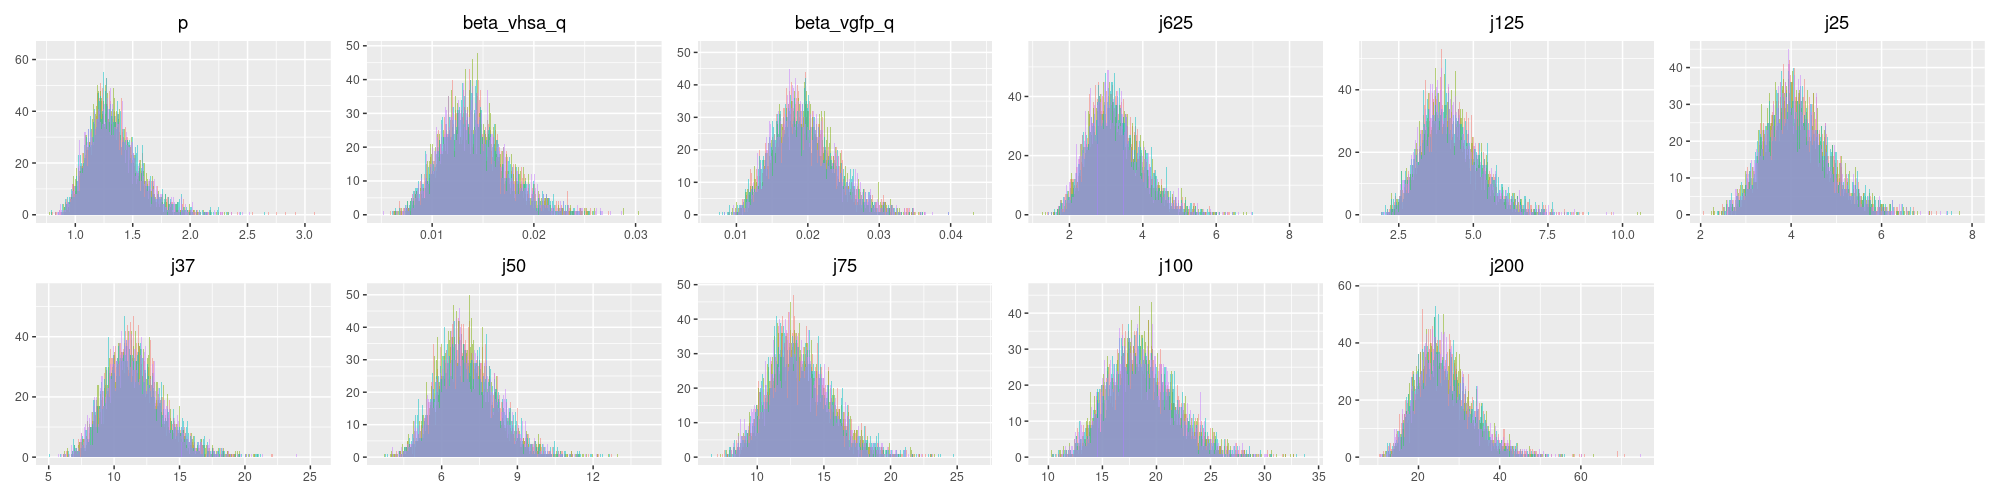

In [189]:
plt <- list()

for (i in 1:11) {
    data_temp <- data.frame(x = df_fit[, i], label = rep(letters[1:4], each = 9000))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = exp(x), fill = label)) +
        geom_histogram(position = "identity", bins = 1000, alpha = 0.5) +
        labs(title = colnames(df_fit)[i]) +
        theme(plot.title = element_text(hjust = 0.5),
              legend.position = 'none',
              axis.title = element_blank())
}

options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(ncol = 6)

In [190]:
plot_HSA_single <- data.frame(x = rep(rep(c("A", "C"), each = 10), 2),
                              y = c(data_gen[1:10, 1], data_gen[1:10, 3],
                                    colMeans(df_fit[, grep("y_HSA", colnames(df_fit))])),
                              ymin = c(rep(NA, 20),
                                       apply(df_fit[, grep("y_HSA", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.025)})),
                              ymax = c(rep(NA, 20),
                                       apply(df_fit[, grep("y_HSA", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.975)})),
                              label = rep(c("A", "B"), each = 20),
                              exp = rep(1:10, 4))

plot_GFP_single <- data.frame(x = rep(rep(c("C", "D"), each = 10), 2),
                              y = c(data_gen[11:20, 3], data_gen[11:20, 4],
                                    colMeans(df_fit[, grep("y_GFP", colnames(df_fit))])),
                              ymin = c(rep(NA, 20),
                                       apply(df_fit[, grep("y_GFP", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.025)})),
                              ymax = c(rep(NA, 20),
                                       apply(df_fit[, grep("y_GFP", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.975)})),
                              label = rep(c("A", "B"), each = 20),
                              exp = rep(1:10, 4))

plot_co <- data.frame(x = rep(rep(c("A", "B", "C", "D"), each = 18), 2),
                      y = c(c(data_gen[21:38, ]),
                            colMeans(df_fit[, grep("y_co", colnames(df_fit))])),
                      ymin = c(rep(NA, 18*4),
                               apply(df_fit[, grep("y_co", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.025)})),
                      ymax = c(rep(NA, 18*4),
                               apply(df_fit[, grep("y_co", colnames(df_fit))], 2, function(x) {quantile(x, probs = 0.975)})),
                      label = rep(c("A", "B"), each = 18*4),
                      exp = rep(1:18, 8))

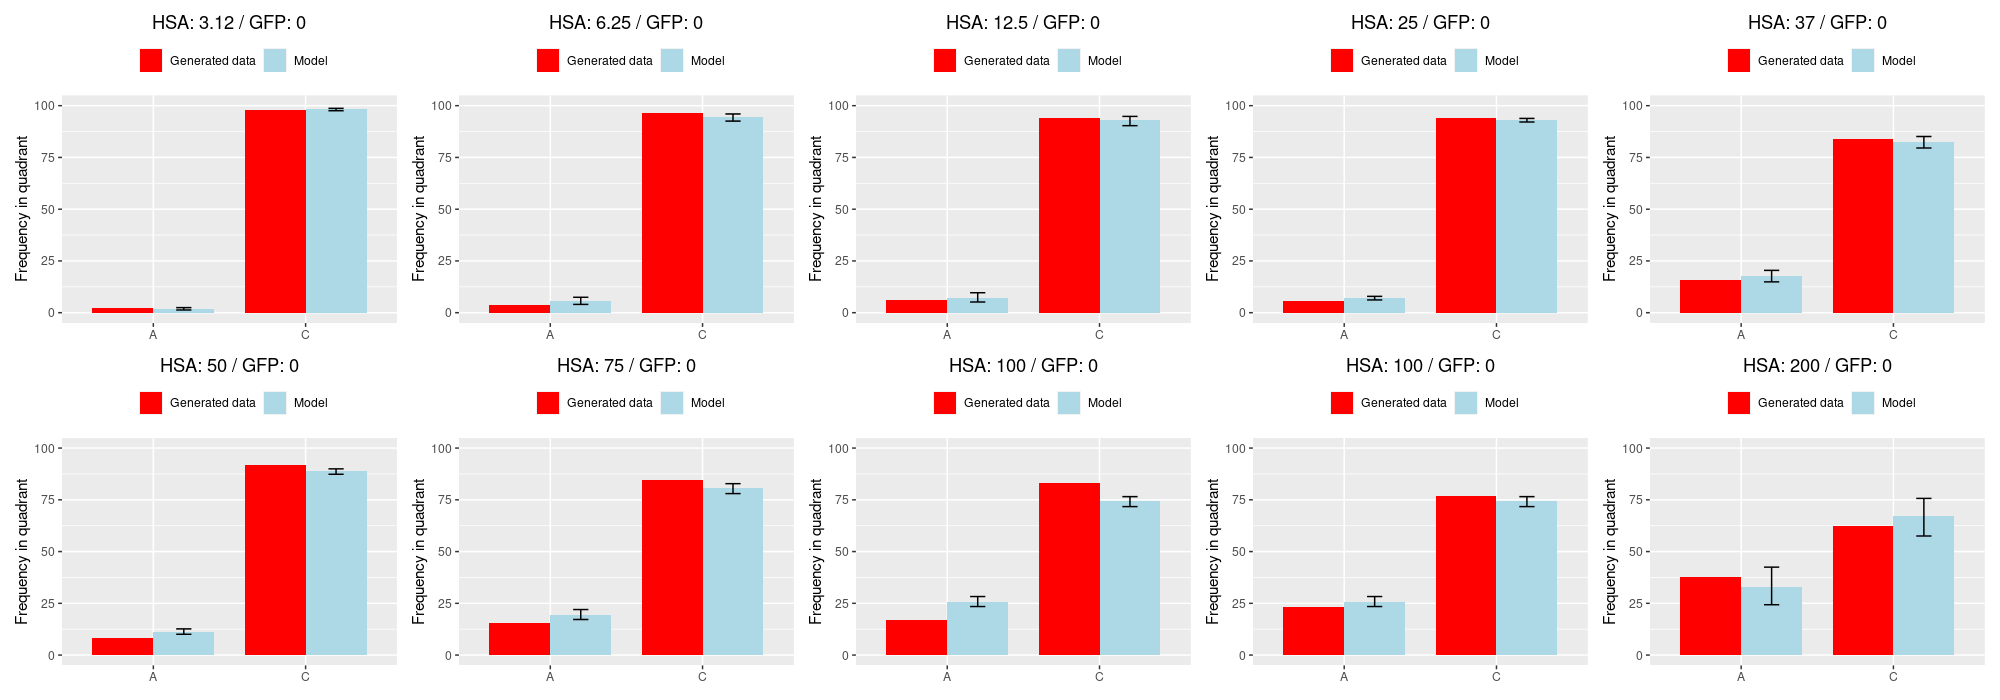

In [191]:

plt <- list()

for (i in unique(plot_HSA_single$exp)) {
    plt[[i]] <- ggplot(data = subset(plot_HSA_single, exp == i), aes(x = x, y = y, ymin = ymin, ymax = ymax, fill = label)) +
        geom_bar(stat = "identity", position = "dodge", width = 0.8) +
        geom_errorbar(position = position_dodge(.8), width = 0.2) +
        scale_fill_manual(values = c(A = "red", B = "lightblue"), label = c(A = "Generated data", B = "Model")) +
        scale_y_continuous(limits = c(0, 100)) +
        ylab("Frequency in quadrant") +
        labs(title = paste("HSA:", dose_exp$hsa[i], "/ GFP:", dose_exp$gfp[i])) +
        theme(legend.position = 'top',
              legend.title = element_blank(),
              axis.title.x = element_blank(),
              plot.title = element_text(hjust = 0.5))
}

options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)


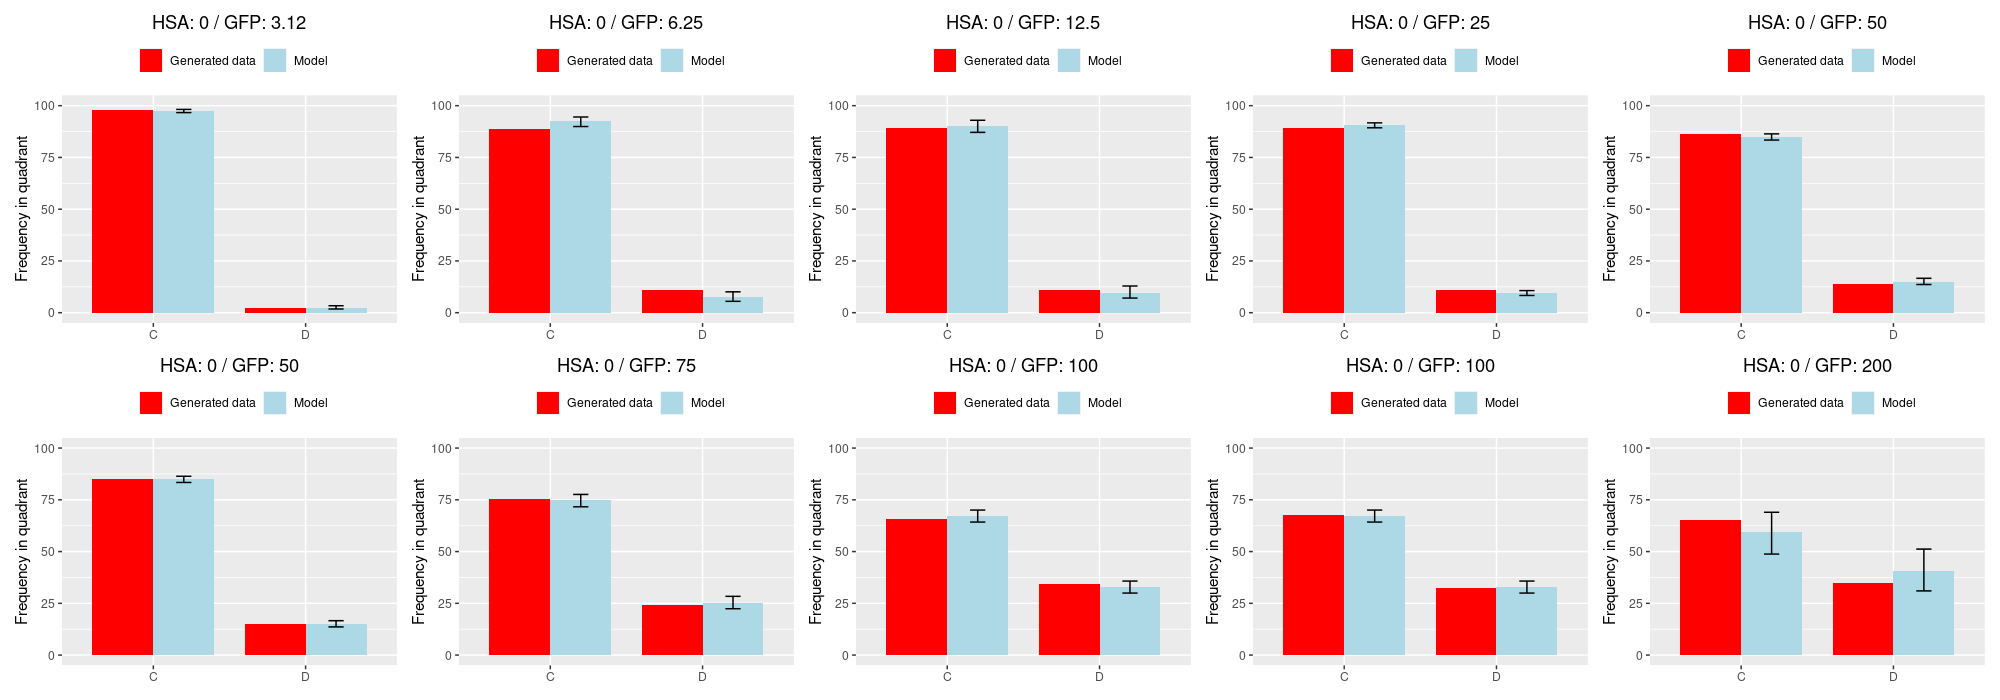

In [192]:

plt <- list()

for (i in unique(plot_GFP_single$exp)) {
    plt[[i]] <- ggplot(data = subset(plot_GFP_single, exp == i), aes(x = x, y = y, ymin = ymin, ymax = ymax, fill = label)) +
        geom_bar(stat = "identity", position = "dodge", width = 0.8) +
        geom_errorbar(position = position_dodge(.8), width = 0.2) +
        scale_fill_manual(values = c(A = "red", B = "lightblue"), label = c(A = "Generated data", B = "Model")) +
        scale_y_continuous(limits = c(0, 100)) +
        ylab("Frequency in quadrant") +
        labs(title = paste("HSA:", dose_exp$hsa[i + 10], "/ GFP:", dose_exp$gfp[i + 10])) +
        theme(legend.position = 'top',
              legend.title = element_blank(),
              axis.title.x = element_blank(),
              plot.title = element_text(hjust = 0.5))
}

options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 2)


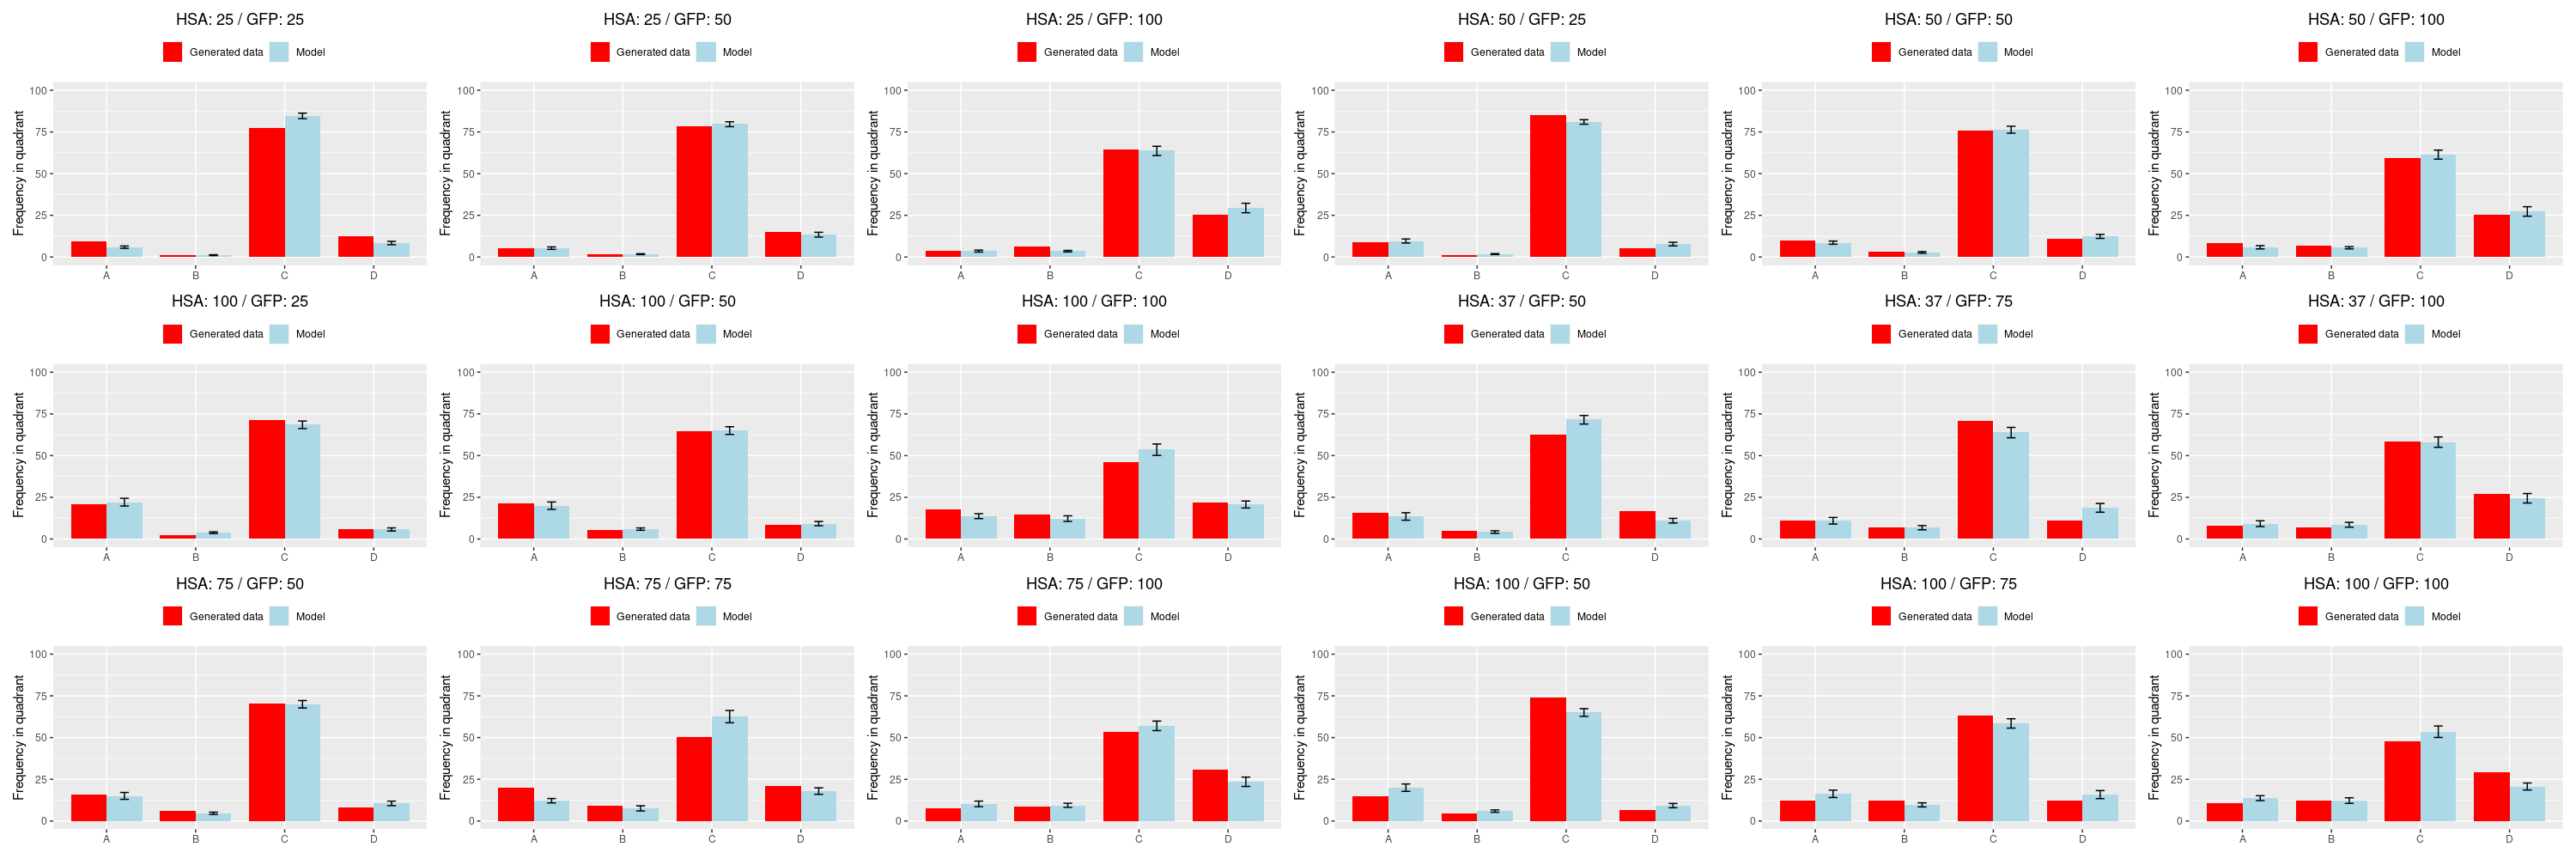

In [193]:

plt <- list()

for (i in unique(plot_co$exp)) {
    plt[[i]] <- ggplot(data = subset(plot_co, exp == i), aes(x = x, y = y, ymin = ymin, ymax = ymax, fill = label)) +
        geom_bar(stat = "identity", position = "dodge", width = 0.8) +
        geom_errorbar(position = position_dodge(.8), width = 0.2) +
        scale_fill_manual(values = c(A = "red", B = "lightblue"), label = c(A = "Generated data", B = "Model")) +
        scale_y_continuous(limits = c(0, 100)) +
        ylab("Frequency in quadrant") +
        labs(title = paste("HSA:", dose_exp$hsa[i + 20], "/ GFP:", dose_exp$gfp[i + 20])) +
        theme(legend.position = 'top',
              legend.title = element_blank(),
              axis.title.x = element_blank(),
              plot.title = element_text(hjust = 0.5))
}

options(repr.plot.width = 30, repr.plot.height = 10, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(nrow = 3)


### 常微分方程式

ウイルスダイナミクスのような常微分方程式系によるシミュレーションと併せたベイズ推定手法を紹介する。

式（2.12）

$$
\begin{align}
\frac{d T \left( t \right)}{dt} &= L(t) - \beta T(t) V(t) \\
\frac{d I \left( t \right)}{dt} &= \beta T(t) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について
$L(t) = \lambda - d T(t), \lambda = 0, d = 0.057, \beta = 8.61 \times 10^{-11}, \delta = 0.057 + 1.75, p = 3.26 \times 10^4, c = 1.93 + 0.039, T(0) = 6.46 \times 10^6, I(0) = 10^{-1}, V(0) = 5.0 \times 10^4$

In [271]:
## 擬似データ生成

## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 20.0
step_size <- 0.001

## パラメータの設定
## lambda, d, beta, delta, p, c, T(0), I(0), V(0)
pars <- c(0.0, 0.057, 8.61*(10.0^-11.0),
          0.057 + 1.75, 3.26*(10.0^4.0), 1.93 + 0.039,
          6.46*(10.0^6.0), 10.0^-1.0, 5.0*(10.0^4.0))

## 傾き（微分）の定義
ode_derives <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        ## var: T(t), I(t), V(t)
        dTdt <- plambda - d * TC - beta * TC * VL
        dIdt <- beta * TC * VL - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dTdt, dIdt, dVdt)))
    })
}

## パラメータを受け取ってode関数に渡す関数
ODEs <- function(parms) {
    pars <- parms[1:6]
    names(pars) <- c("plambda", "d", "beta", "delta", "p", "c")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[7], IC = parms[8], VL = parms[9])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives, parms = pars)
    
    as.data.frame(out)
}

In [272]:
out <- ODEs(pars)

In [273]:
set.seed(0987)
time_sample <- (seq(2, 20, by = 2)/step_size) + 1

data_sample <- out[time_sample, ]

for (i in 1:3) {
    data_sample[, i + 1] <- exp(log(data_sample[, i + 1]) + rnorm(nrow(data_sample), mean = 0, sd = 1))
}

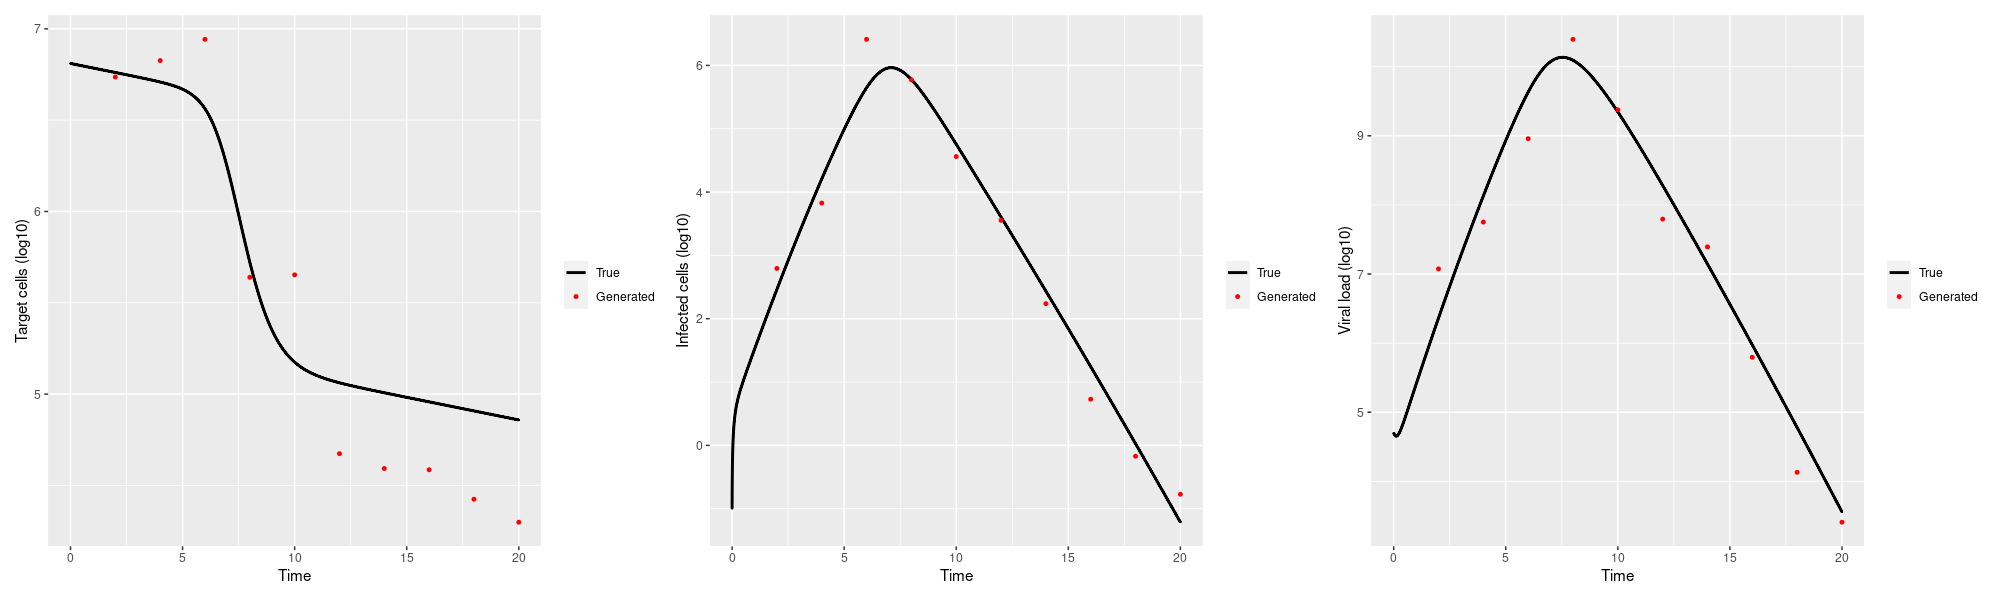

In [274]:
plt <- list()

for (i in 1:3) {
    data_temp <- rbind(cbind(out, label = "True"), cbind(data_sample, label = "Generated"))[, c("time", c("TC", "IC", "VL")[i], "label")]
    colnames(data_temp)[2] <- "y"
    data_temp$label <- factor(data_temp$label, levels = c("True", "Generated"))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = time, y = log10(y), color = label, linewidth = label, size = label)) +
        geom_line() +
        geom_point() +
        scale_color_manual(values = c(True = "black", Generated = "red")) +
        scale_size_manual(values = c(True = 0, Generated = 1)) +
        scale_linewidth_manual(values = c(True = 1, Generated = 0)) +
        xlab("Time") +
        ylab(c("Target cells (log10)", "Infected cells (log10)", "Viral load (log10)")[i]) +
        theme(legend.title = element_blank())
}

options(repr.plot.width = 20, repr.plot.height = 6, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt)

In [296]:
model_stan_ode = '
functions {
   vector virusdynamics(
      real t,
      vector y,
      real d,
      real beta,
      real delta,
      real p,
      real c
   ) {
      vector[3] dydt;
      dydt[1] = - d*y[1] - beta*y[1]*y[3];
      dydt[2] = beta*y[1]*y[3] - delta*y[2];
      dydt[3] = p*y[2] - c*y[3];
      return dydt;
   }
}

data {
   int<lower=1> num_data_points;
   int<lower=1> num_model_parameters;
   int<lower=1> num_initial_states;
   
   real time_start;
   
   array[num_data_points] real time_observed;
   array[num_data_points] real TC_observed;
   array[num_data_points] real IC_observed;
   array[num_data_points] real VL_observed;
}

parameters {
   // model parameters
   real<lower=log(1e-11), upper=log(1e-10)> beta;
   real<lower=log(1e+4), upper=log(1e+5)> p;
   real<lower=log(1e+4), upper=log(1e+5)> V0L;

   // standard deviation of error model
   real<lower=0, upper=100> sigma;
}

transformed parameters {
   real d = log(0.057);
   real delta = log(0.057 + 1.75);
   real c = log(1.93 + 0.039);
   real T0C = log(6.46*(10.0^6.0));
   real I0C = log(10.0^-1.0);
   
   vector[num_initial_states] Y0;
   
   Y0[1] = exp(T0C);
   Y0[2] = exp(I0C);
   Y0[3] = exp(V0L);
   
   array[num_data_points] vector<lower=0, upper=1e+20>[3] y_hat;
   
   // https://mc-stan.org/docs/functions-reference/functions-old-ode-solver.html
   y_hat = ode_rk45_tol(virusdynamics, Y0, time_start, time_observed, 1e-10, 1e-10, 10000000, exp(d), exp(beta), exp(delta), exp(p), exp(d));
   //y_hat = ode_rk45(virusdynamics, Y0, time_start, time_observed, exp(d), exp(beta), exp(delta), exp(p), exp(d));
}

model {
   
   //beta ~ normal(log(5e-11), 1); //8.61*(10.0^-11.0)
   //p ~ normal(log(5e+4), 1); //3.26*(10.0^4.0)
   //V0L ~ normal(log(1e+5), 1); //5.0*(10.0^4.0)
   
   beta ~ uniform(log(1e-11), log(1e-10)); //8.61*(10.0^-11.0)
   p ~ uniform(log(1e+4), log(1e+5)); //3.26*(10.0^4.0)
   V0L ~ uniform(log(1e+4), log(1e+5)); //5.0*(10.0^4.0)
   
   for (i in 1:num_data_points) {
       TC_observed[i] ~ lognormal(log(y_hat[i, 1]), sigma);
       IC_observed[i] ~ lognormal(log(y_hat[i, 2]), sigma);
       VL_observed[i] ~ lognormal(log(y_hat[i, 3]), sigma);
       
   }
   
   sigma ~ normal(0.5,0.5);
   
}
'

一言メモ：

数値計算の安定化のために探索範囲を狭く設定しています。微分方程式のモデルによっては、パラメータの値によって数値計算の誤差が大きくなりすぎて計算が困難になる場合があります。  
実際には、パラメータの生物学的な意味を考えて探索範囲を限定したり、コード2-2で紹介した最小二乗法などでパラメータの値にあたりをつけてから、その周辺でサンプリングを行うのが良いです。  
または、数値計算誤差の許容範囲（tolerance）や数値計算を行う各ステップ間の間隔、ステップ数などを調整すると解決することもありますが、大きくなってしまう計算時間との兼ね合いです。

In [297]:
data_stan <- list(num_data_points = nrow(data_sample),
                  num_model_parameters = 5,
                  num_initial_states = 3,
                  time_start = 0,
                  time_observed = data_sample$time,
                  TC_observed = data_sample$TC,
                  IC_observed = data_sample$IC,
                  VL_observed = data_sample$VL)

In [298]:
set.seed(5)
num_chain <- 4
init_stan <- list()
for (i in 1:4) {
  init_stan[[i]] <- list(beta = runif(1, min = log(1e-11), max = log(1e-10)),
                         p = runif(1, min = log(1e+4), max = log(1e+5)),
                         V0L = runif(1, min = log(1e+4), max = log(1e+5)),
                         sigma = 0.1)
}

In [299]:
time_start <- Sys.time()

fit <- stan(model_code = model_stan_ode, data = data_stan,
            init = init_stan,
            seed = 1,
            chains = num_chain, iter = 10000, warmup = 1000,
            cores = getOption("mc.cores", 4L),
            verbose = FALSE)

time_end <- Sys.time()
print(time_end - time_start)

Warning message:
“There were 39 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


Time difference of 16.74342 mins


In [279]:
df_fit <- as.data.frame(fit)

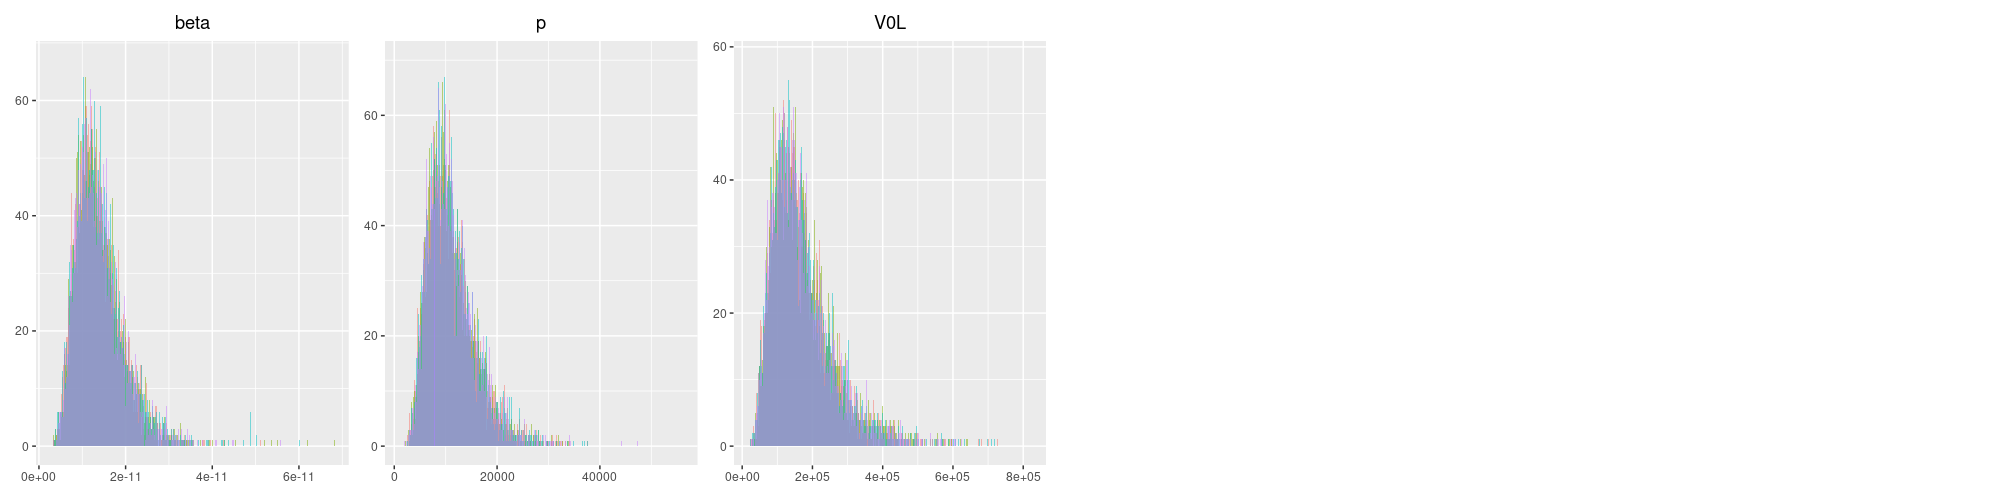

In [280]:
plt <- list()

for (i in 1:3) {
    data_temp <- data.frame(x = df_fit[, i], label = rep(letters[1:4], each = 9000))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = exp(x), fill = label)) +
        geom_histogram(position = "identity", bins = 1000, alpha = 0.5) +
        labs(title = colnames(df_fit)[i]) +
        theme(plot.title = element_text(hjust = 0.5),
              legend.position = 'none',
              axis.title = element_blank())
}

options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(ncol = 6)

In [281]:
head(df_fit)

,beta,p,V0L,sigma,d,delta,c,T0C,I0C,Y0[1],⋯,"y_hat[2,3]","y_hat[3,3]","y_hat[4,3]","y_hat[5,3]","y_hat[6,3]","y_hat[7,3]","y_hat[8,3]","y_hat[9,3]","y_hat[10,3]",lp__
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-24.96945,8.837372,11.94371,6.232233,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,334711.0,488751.5,680567.5,907478.5,1163244.4,1438578.9,1722109.1,2001578.9,2265071.3,-93.01236
2,-25.05248,9.144279,12.10711,5.889589,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,491834.1,799152.9,1226876.3,1788278.2,2485948.5,3309703.8,4236506.4,5232408.0,6256071.9,-92.18724
3,-25.06737,9.550174,12.35670,5.781432,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,1033704.1,2127789.9,4058417.0,7216665.8,12032397.7,18911176.9,28157148.5,39898905.0,54036570.1,-93.03949
4,-25.38563,9.651537,12.35096,5.777154,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,768149.3,1375036.8,2306837.1,3646669.6,5459338.7,7776469.4,10585529.9,13825487.0,17390177.8,-92.93721
5,-25.14051,8.729318,12.06971,4.979711,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,303158.5,396964.3,500526.6,609806.3,720160.4,826818.9,925338.7,1011967.6,1083881.0,-93.53379
6,-25.42765,8.956113,11.54366,6.346163,-2.864704,0.591668,0.6775258,15.68114,-2.302585,6460000,⋯,172123.0,220820.1,273302.8,327405.7,380792.4,431185.8,476570.2,515337.8,546370.2,-93.99918


In [282]:
pars_mcmc <- exp(df_fit[sample(1:nrow(df_fit), 100), c("beta", "p", "V0L")])

In [295]:
time_start <- Sys.time()
tc_sample <- data.frame()
ic_sample <- data.frame()
vl_sample <- data.frame()

plot_mcmc[[1]] <- data_sample
for (i in 1:nrow(pars_mcmc)) {
    pars_temp <- pars
    pars_temp[c(3, 5, 9)] <- unlist(pars_mcmc[i,])
    out <- ODEs(pars_temp)
    
    tc_sample <- rbind(tc_sample, out$TC)
    ic_sample <- rbind(ic_sample, out$IC)
    vl_sample <- rbind(vl_sample, out$VL)
}
time_end <- Sys.time()
print(time_end - time_start)

Time difference of 50.55817 secs


ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 0, 20001
